In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl
from astropy.io import fits

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.3175, Omega_b = 0.049, h = 0.6711, sigma8 = 0.834, n_s = 0.9649, 
                      matter_power_spectrum='linear')

#Config params. Can change as you need. I store these as a dict and then unpack.
bpar = np.load('./default_config.npy', allow_pickle = True)[()]

#Just to make the variation in params more extreme
bpar['mu_beta'] = 1

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

## Download files

These are files from the [ULAGAM simulations](https://ulagam-simulations.readthedocs.io/) hosted on gdrive specifically for this example notebook

In [3]:
!rm shell.fits.fz halos.npy TNG.npz
!wget -O shell.fits.fz "https://drive.google.com/uc?export=download&id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6"
!wget -O halos.npy     "https://drive.google.com/uc?export=download&id=1JhtFwOzfHG5YWXUDYP1HFfAkq6v5YHKm"
!wget -O TNG.npz       "https://drive.google.com/uc?export=download&id=1EZ5zJ-jBZ8Vs8EtLNcPb_JDJcLn4nsW_"

--2025-12-05 10:09:55--  https://drive.google.com/uc?export=download&id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6
Resolving drive.google.com (drive.google.com)... 142.250.190.14, 2607:f8b0:4009:801::200e
Connecting to drive.google.com (drive.google.com)|142.250.190.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6&export=download [following]
--2025-12-05 10:09:55--  https://drive.usercontent.google.com/download?id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.191.225, 2607:f8b0:4009:81c::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.191.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5705280 (5.4M) [application/octet-stream]
Saving to: ‘shell.fits.fz’

shell.fits.fz       100%[===================>]   5.44M  7.63MB/s    in 0

# Run on TNG

In [4]:
Maps = np.load('TNG.npz', allow_pickle = True)

Map_DMO   = Maps['Map_DMO']
Map_FP    = Maps['Map_FP']
Map_Gas   = Maps['Map_Gas']
Map_Stars = Maps['Map_Stars']
Halos_DMO = Maps['Halos_DMO'][()]

Lbox      = 205/0.6774

In [75]:
min_z = 0
max_z = 0.01
med_z = 1e-8

bpar_TNG = {k : v for k, v in bpar.items()}
bpar_TNG['theta_ej'] = 0.6
bpar_TNG['epsilon_max'] = 5
bpar_TNG['proj_cutoff'] = Lbox / 2
bpar_TNG['mu_beta'] = 0.2
bpar_TNG['M_c'] = 1e13

#Get the pressure profile
Gas = bfg.Profiles.Gas(**bpar_TNG)
DMB = bfg.Profiles.DarkMatterBaryon(**bpar_TNG, twohalo = bfg.Profiles.misc.Zeros()) #No two-halo term in hydrostatic equation

#Now add the HealPix pixel (a redshift-dependent kernel)
Pix = bfg.utils.GridPixelApprox(Lbox / Map_DMO.shape[0])

#Now tabulate it (this does both 3D and 2D tabulation)
Gas = bfg.utils.ConvolvedProfile(Gas, Pix)
Gas = bfg.utils.TabulatedProfile(Gas, cosmo)
Gas.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                       R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)

#Now tabulate it (this does both 3D and 2D tabulation)
STR = bfg.Profiles.Stars(**bpar_TNG)
STR = bfg.utils.ConvolvedProfile(STR, Pix)
STR = bfg.utils.TabulatedProfile(STR, cosmo)
STR.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                       R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)


#Now tabulate it (this does both 3D and 2D tabulation)
DMB = bfg.utils.ConvolvedProfile(DMB, Pix)
DMB = bfg.utils.TabulatedProfile(DMB, cosmo)
DMB.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                       R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)


#Now tabulate it (this does both 3D and 2D tabulation)
DMB_LS = bfg.Profiles.DarkMatterBaryon(**bpar_TNG)
DMB_LS = bfg.utils.ConvolvedProfile(DMB_LS, Pix)

DMO_LS = bfg.Profiles.DarkMatterOnly(**bpar_TNG)
DMO_LS = bfg.utils.ConvolvedProfile(DMO_LS, Pix)

Displ  = bfg.Profiles.Baryonification2D(DMO_LS, DMB_LS, cosmo, epsilon_max = bpar_TNG['epsilon_max'])
Displ.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                         R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)

Building Table: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.40s/it]


In [76]:
#Each model gets its own runner
cdict   = {'Omega_m' : 0.3089, 'sigma8' : 0.8159, 'h' : 0.6774, 'n_s' : 0.9667, 'w0' : -1, 'Omega_b' : 0.0486}
halos   = bfg.utils.HaloNDCatalog(Halos_DMO['pos'][:,0], Halos_DMO['pos'][:,1], Halos_DMO['M200c'], redshift = 0, cosmo = cdict)

In [77]:
#Just need an empty shell to paint into, so feed it an empty map at the NSIDE you want
bins    = np.linspace(0, 205/0.6774, Map_DMO.shape[0] + 1)
bins    = (bins[1:] + bins[:-1])/2
Maps    = bfg.utils.GriddedMap(Map_DMO, cosmo = cdict, redshift = med_z, bins = bins)

Map_DMO_d = bfg.Runners.BaryonifyGrid(halos, Maps, bpar_TNG['epsilon_max'], Displ).process()
Maps    = bfg.utils.GriddedMap(Map_DMO_d, cosmo = cdict, redshift = med_z, bins = bins)

GasRunner = bfg.Runners.PaintProfilesGrid(halos, Maps, epsilon_max = bpar['epsilon_max'], model = Gas, verbose = True, include_pixel_size = False)
GasAnis   = bfg.Runners.PaintProfilesAnisGrid(halos, Maps, epsilon_max = bpar['epsilon_max'], model = bfg.Profiles.Identity(), 
                                               Tracer_model = Gas, Mtot_model = DMB, verbose = True, 
                                               global_tracer_fraction = 0.15, background_val = 1,
                                               include_pixel_size = False)

Baryonifying matter: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 47372/47372 [01:02<00:00, 753.14it/s]


In [78]:
np.sum(halos.cat['M']) / (205/0.6774)**3 / cosmo.rho_x(1, species = 'matter', is_comoving = True)

0.2553070620557219

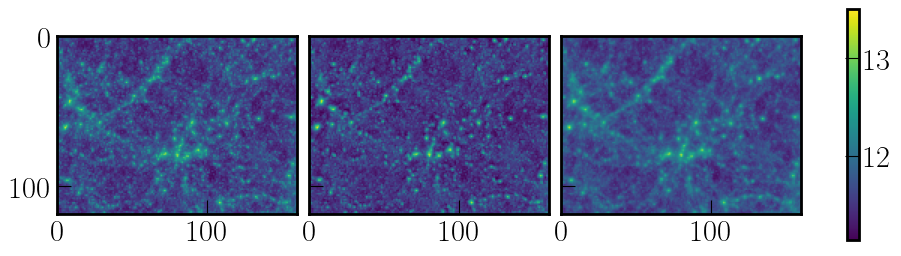

In [95]:
j = 8
D = 80

xmid  = np.digitize(halos.cat['x'][j], bins)
ymid  = np.digitize(halos.cat['y'][j], bins)
xinds = slice(xmid - D, xmid + D)
yinds = slice(ymid - D, ymid + D)

fig, ax = plt.subplots(1, 3, figsize = (12, 3), sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)

ax[0].imshow(np.log10(Map_DMO * 0.15)[xinds].T[yinds],    vmin = np.log10(np.min(Map_Gas)), vmax = np.log10(np.max(Map_Gas)))
ax[1].imshow(np.log10(Map2)[xinds].T[yinds],    vmin = np.log10(np.min(Map_Gas)), vmax = np.log10(np.max(Map_Gas)))
c = ax[2].imshow(np.log10(Map_Gas)[xinds].T[yinds], vmin = np.log10(np.min(Map_Gas)), vmax = np.log10(np.max(Map_Gas)))

plt.colorbar(c, ax = ax[:])
plt.show()

In [99]:
np.sum(Map2) / np.sum(Map_DMO)

0.1136073438079225

In [100]:
np.sum(Map1) / np.sum(Map_DMO)

0.14506965479162529

In [98]:
GasAnis   = bfg.Runners.PaintProfilesAnisGrid(halos, Maps, epsilon_max = 10, model = bfg.Profiles.Identity(), 
                                                   Tracer_model = Gas, Mtot_model = DMB, verbose = True, 
                                                   global_tracer_fraction = 0.15, background_val = 1,
                                                   include_pixel_size = False)
Map2 = GasAnis.process()

GasAnis   = bfg.Runners.PaintProfilesGrid(halos, Maps, epsilon_max = 10, model = Gas, verbose = True, include_pixel_size = False)
Map1 = GasAnis.process()

Painting field: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 47372/47372 [00:23<00:00, 2049.22it/s]


Inputted halos contribute 29.73% of the total matter density.
Remaining density is assigned to a uniform background.


Painting field: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 47372/47372 [00:25<00:00, 1888.38it/s]


Painting field: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 47372/47372 [00:56<00:00, 838.06it/s]


Inputted halos contribute 29.73% of the total matter density.
Remaining density is assigned to a uniform background.


Painting field: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 47372/47372 [00:53<00:00, 881.75it/s]
/tmp/ipykernel_2865/3440043004.py:25: RuntimeWarning: divide by zero encountered in log10
  ax[0].imshow(np.log10(Map1)[xinds].T[yinds],    vmin = np.log10(np.min(Map_Gas)), vmax = np.log10(np.max(Map_Gas)))


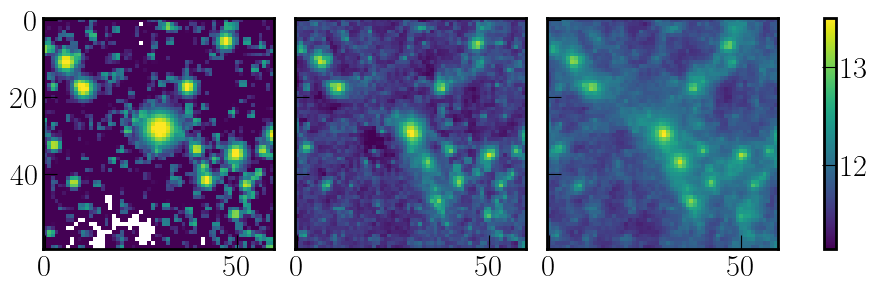

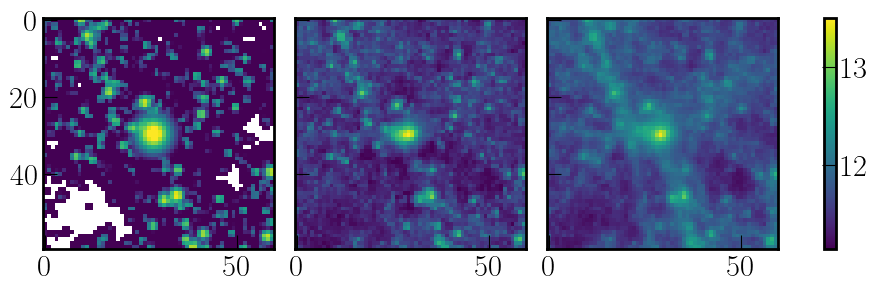

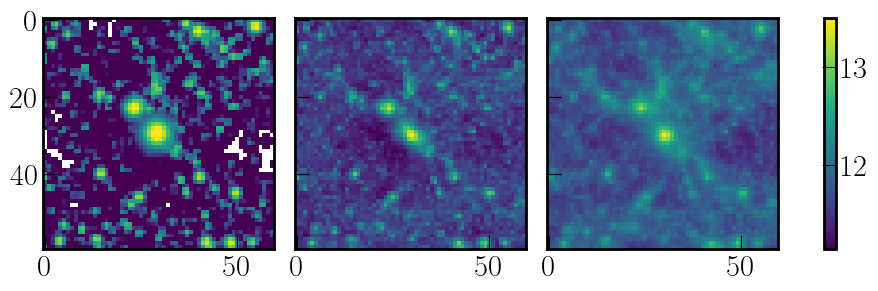

In [88]:
GasAnis   = bfg.Runners.PaintProfilesAnisGrid(halos, Maps, epsilon_max = 10, model = bfg.Profiles.Identity(), 
                                                   Tracer_model = Gas, Mtot_model = DMB, verbose = True, 
                                                   global_tracer_fraction = 0.15, background_val = 1,
                                                   include_pixel_size = False)
Map2 = GasAnis.process()

GasAnis   = bfg.Runners.PaintProfilesGrid(halos, Maps, epsilon_max = 10, model = Gas, verbose = True, include_pixel_size = False)
Map1 = GasAnis.process()


for j in range(3):
    xmid  = np.digitize(halos.cat['x'][j], bins)
    ymid  = np.digitize(halos.cat['y'][j], bins)
    xinds = slice(xmid - 30, xmid + 30)
    yinds = slice(ymid - 30, ymid + 30)

    inds      = np.sqrt(
                    (halos.cat['x'] - halos.cat['x'][0])**2 + 
                    (halos.cat['y'] - halos.cat['y'][0])**2
                ) < (30 * (bins[1] - bins[0]))

    fig, ax = plt.subplots(1, 3, figsize = (12, 3), sharex = True, sharey = True)
    plt.subplots_adjust(wspace = 0.05)

    ax[0].imshow(np.log10(Map_DMO * 0.15)[xinds].T[yinds],    vmin = np.log10(np.min(Map_Gas)), vmax = np.log10(np.max(Map_Gas)))
    ax[1].imshow(np.log10(Map2)[xinds].T[yinds],    vmin = np.log10(np.min(Map_Gas)), vmax = np.log10(np.max(Map_Gas)))
    c = ax[2].imshow(np.log10(Map_Gas)[xinds].T[yinds], vmin = np.log10(np.min(Map_Gas)), vmax = np.log10(np.max(Map_Gas)))

    plt.colorbar(c, ax = ax[:])
    plt.show()

/tmp/ipykernel_2296/3582525977.py:5: RuntimeWarning: divide by zero encountered in log10
  ax[2].imshow( np.log10(Map_Stars) )


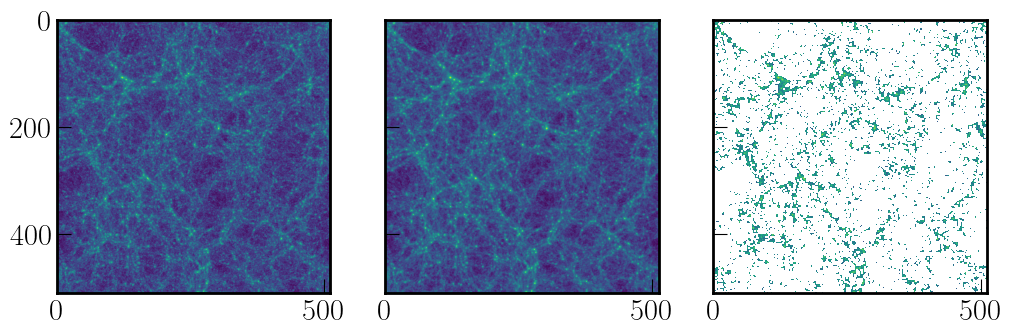

In [110]:
fig, ax = plt.subplots(2, 3, figsize = (12,8), sharex = True, sharey = True)

ax[0, 0].imshow( np.log10(Map_DMO) )
ax[0, 1].imshow( np.log10(Map_Gas) )
ax[0, 2].imshow( np.log10(Map_Stars) )

# Run on Ulagam

In [25]:
min_z = 0.2129219
max_z = 0.2395602
med_z = (min_z + max_z)/2

halo_file = np.load('halos.npy')
density   = fits.open('./shell.fits.fz')[1].data


#Compute thickness of the shell for projection scale
shell_thickness = ccl.comoving_radial_distance(cosmo, 1/(max_z + 1)) - ccl.comoving_radial_distance(cosmo, 1/(min_z + 1))
bpar['proj_cutoff'] = shell_thickness/2

print(f"SHELL IS {shell_thickness} MPC")


#This is set in units of halo R200c radius.
#You want this to be larger than the radius where you displacement
#function asymptotes to 0
bpar['epsilon_max'] = 10

SHELL IS 103.99377732916025 MPC


In [34]:
#Get the pressure profile
Gas = bfg.Profiles.Gas(**bpar)
DMB = bfg.Profiles.DarkMatterBaryon(**bpar, twohalo = bfg.Profiles.misc.Zeros()) #No two-halo term in hydrostatic equation
PRS = bfg.Profiles.Pressure(gas = Gas, darkmatterbaryon = DMB)
PRS = bfg.Profiles.ThermalSZ(PRS) #Converts Pressure from cgs to compton-y (dimensionless) units
PRS = bfg.Profiles.misc.ComovingToPhysical(PRS, factor = -3) #Convert to physical units correctly before painting

#Now add the HealPix pixel (a redshift-dependent kernel)
Pix = bfg.utils.HealPixel(NSIDE = 1024)
PRS = bfg.utils.ConvolvedProfile(PRS, Pix)
PRS = bfg.utils.TabulatedProfile(PRS, cosmo)
PRS.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                       R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)

#Now tabulate it (this does both 3D and 2D tabulation)
Gas = bfg.utils.ConvolvedProfile(Gas, Pix)
Gas = bfg.utils.TabulatedProfile(Gas, cosmo)
Gas.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                       R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)

#Now tabulate it (this does both 3D and 2D tabulation)
STR = bfg.Profiles.Stars(**bpar)
STR = bfg.utils.ConvolvedProfile(STR, Pix)
STR = bfg.utils.TabulatedProfile(STR, cosmo)
STR.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                       R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)


#Now tabulate it (this does both 3D and 2D tabulation)
DMB = DMB * bfg.Profiles.Truncation(epsilon_trunc = 4)
DMB = bfg.utils.ConvolvedProfile(DMB, Pix)
DMB = bfg.utils.TabulatedProfile(DMB, cosmo)
DMB.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                       R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)

Building Table:   0%|                                                                                                                 | 0/2 [00:00<?, ?it/s]/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Base.py:263: UserWarning: WARNING: Profile is zero/negative in some places.Likely a convolution artifact for objects smaller than the pixel scale
  warnings.warn("WARNING: Profile is zero/negative in some places."
Building Table: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.92s/it]
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/utils/Tabulate.py:270: RuntimeWarning: divide by zero encountered in log
  self.interp3D = interpolate.RegularGridInterpolator(input_grid_1, np.log(interp3D), bounds_error = False)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/utils/Tabulate.py:271: RuntimeWarning: invalid value

In [35]:
#Each model gets its own runner
cdict   = {'Omega_m' : 0.3175, 'sigma8' : 0.834, 'h' : 0.6711, 'n_s' : 0.9649, 'w0' : -1, 'Omega_b' : 0.049}
halos   = bfg.utils.HaloLightConeCatalog(halo_file['ra'], halo_file['dec'], halo_file['M'], halo_file['z'], cosmo = cdict)

In [43]:
#Just need an empty shell to paint into, so feed it an empty map at the NSIDE you want
shell   = bfg.utils.LightconeShell(density, cosmo = cdict, redshift = med_z)
Runners = []

STRRunner = bfg.Runners.PaintProfilesShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = STR, verbose = True, include_pixel_size = False)
GasRunner = bfg.Runners.PaintProfilesShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = Gas, verbose = True, include_pixel_size = False)
PRSRunner = bfg.Runners.PaintProfilesShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = PRS, verbose = True, include_pixel_size = False)

STRAnis   = bfg.Runners.PaintProfilesAnisShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = STR, 
                                               Tracer_model = STR, Mtot_model = DMB, verbose = True, 
                                               global_tracer_fraction = 0, background_val = 1,
                                               include_pixel_size = False)

GasAnis   = bfg.Runners.PaintProfilesAnisShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = bfg.Profiles.Identity(), 
                                               Tracer_model = Gas, Mtot_model = DMB, verbose = True, 
                                               global_tracer_fraction = 0.15, background_val = 1,
                                               include_pixel_size = False)

PRSAnis   = bfg.Runners.PaintProfilesAnisShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = PRS, 
                                               Tracer_model = PRS, Mtot_model = DMB, verbose = True, 
                                               global_tracer_fraction = 0.15, background_val = 1e6,
                                               include_pixel_size = False)

In [44]:
# Map1 = GasRunner.process()
Map2 = GasAnis.process()

Painting Profile: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 18512/18512 [00:28<00:00, 642.60it/s]


Inputted halos contribute 2.03% of the total matter density.
Remaining density is assigned to a uniform background.


Painting Profile: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 18512/18512 [00:32<00:00, 566.29it/s]


/tmp/ipykernel_2296/3434248545.py:1: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(Map2))


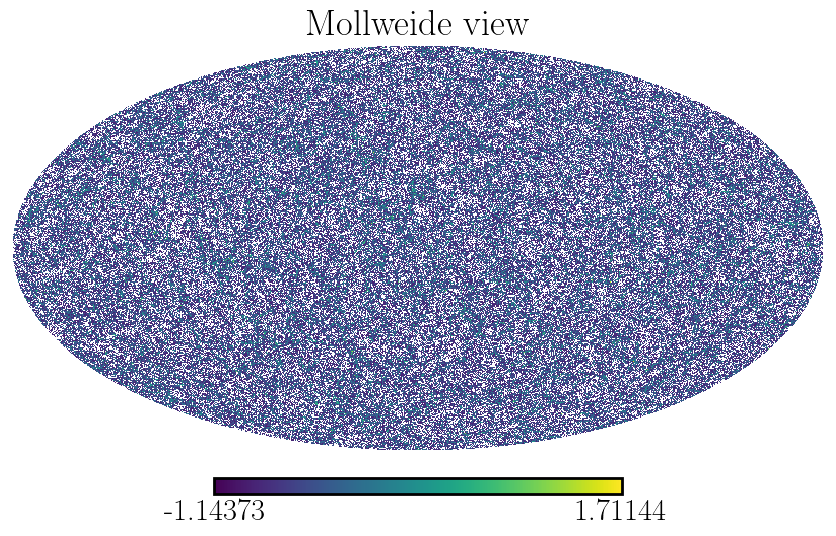

In [45]:
hp.mollview(np.log10(Map2))

In [82]:
#Now tabulate it (this does both 3D and 2D tabulation)
DMO = bfg.Profiles.Schneider19.DarkMatter(**bpar) * bfg.Profiles.Truncation(epsilon_trunc = 4)
DMO = bfg.utils.ConvolvedProfile(DMO, Pix)
DMO = bfg.utils.TabulatedProfile(DMO, cosmo)
DMO.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                       R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)

Building Table:   0%|                                                                                                                 | 0/2 [00:00<?, ?it/s]/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Base.py:263: UserWarning: WARNING: Profile is zero/negative in some places.Likely a convolution artifact for objects smaller than the pixel scale
  warnings.warn("WARNING: Profile is zero/negative in some places."
Building Table: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


In [83]:
DMORunner = bfg.Runners.PaintProfilesShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = DMO, verbose = True, include_pixel_size = False)

In [84]:
# Map1 = GasRunner.process()
Map_halomodel = DMORunner.process()

Painting Profile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 18512/18512 [00:10<00:00, 1707.07it/s]


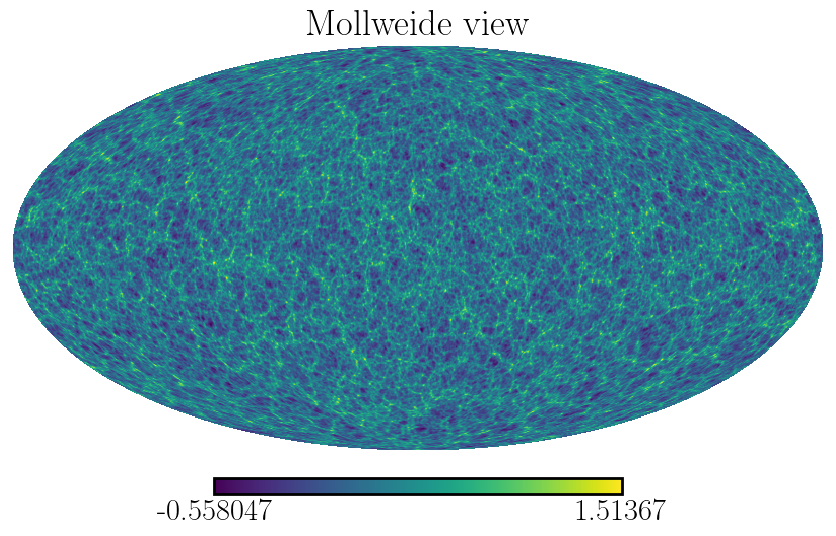

In [52]:
hp.mollview(np.log10(hp.smoothing(density, fwhm = 30 / 60 * np.pi/180)))

/tmp/ipykernel_2296/3846461444.py:1: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(hp.smoothing(Map_halomodel, fwhm = 30 / 60 * np.pi/180)), max = 13.6, min = 10)
/tmp/ipykernel_2296/3846461444.py:1: RuntimeWarning: invalid value encountered in log10
  hp.mollview(np.log10(hp.smoothing(Map_halomodel, fwhm = 30 / 60 * np.pi/180)), max = 13.6, min = 10)


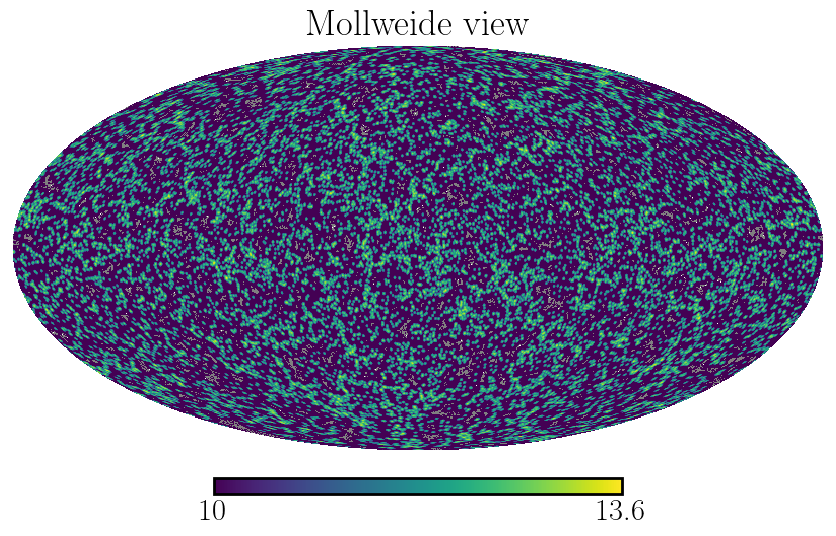

In [71]:
hp.mollview(np.log10(hp.smoothing(Map_halomodel, fwhm = 30 / 60 * np.pi/180)), max = 13.6, min = 10)

In [85]:
AA = hp.anafast(density,       lmax = 2048, use_pixel_weights = True)
BB = hp.anafast(Map_halomodel, lmax = 2048, use_pixel_weights = True)
AB = hp.anafast(density, Map_halomodel, lmax = 2048, use_pixel_weights = True)

In [73]:
ell = np.arange(AA.size)

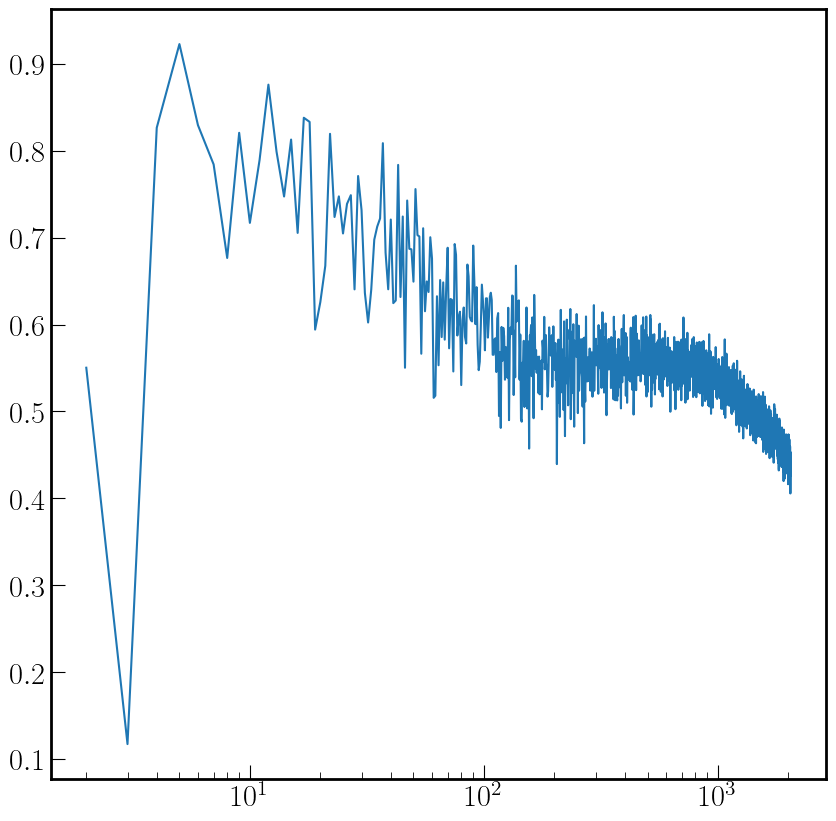

In [86]:
plt.xscale('log')
plt.plot(ell[2:], (AB / np.sqrt(AA * BB))[2:])

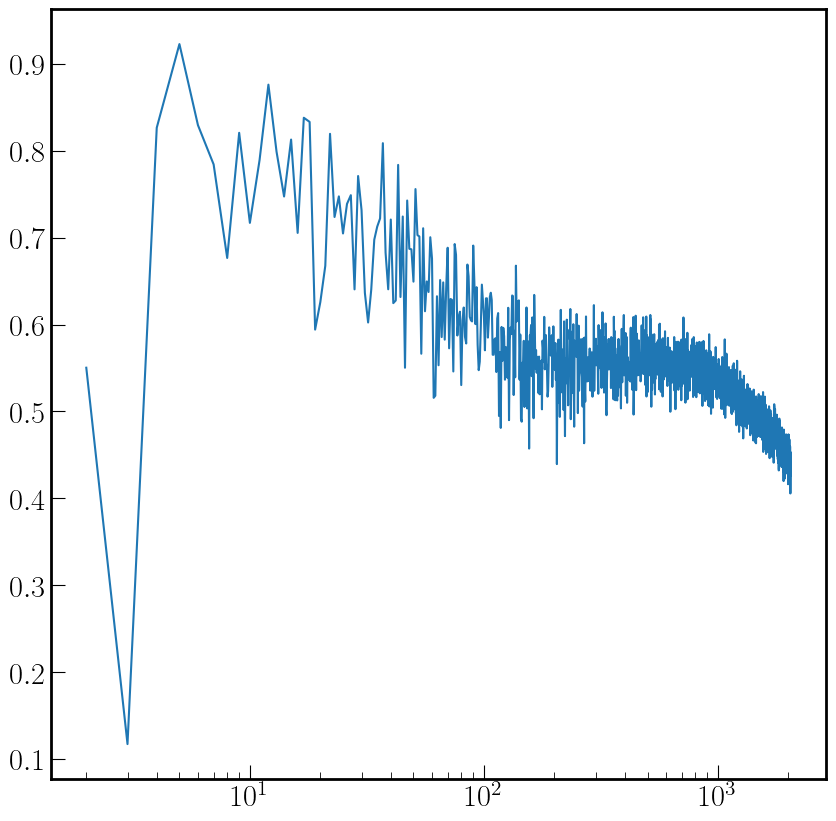

In [75]:
plt.xscale('log')
plt.plot(ell[2:], (AB / np.sqrt(AA * BB))[2:])